### 处理数据集
1、解压数据并划分验证集训练集

In [ ]:
import os
import re
import zipfile
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# 从文件名中提取数字的辅助函数
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0


# 从文件名中提取风暴ID和时间的辅助函数
def extract_storm_id_and_time(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    storm_id = parts[0]
    time = parts[1].split('.')[0]
    return storm_id, time

# 按风暴ID分组
storm_groups = defaultdict(list)
for img in all_images:
    storm_id, _ = extract_storm_id_and_time(img)
    storm_groups[storm_id].append(img)

# 解压缩文件
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# 从文件名中提取数字的辅助函数
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0        
        
# 加载并排序图像文件
def load_images_sorted(directory):
    images = []
    for root, _, files in os.walk(directory):
        for fname in files:
            if fname.endswith('.jpg'):
                full_path = os.path.join(root, fname)
                images.append(full_path)
    images.sort(key=extract_number)
    return images

# 从文件名中提取风暴ID和时间的辅助函数
def extract_storm_id_and_time(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    storm_id = parts[0]
    time = parts[1].split('.')[0]
    return storm_id, time

zip_path = "F:\\大数据期末\\storm.zip"
extract_to ="F:\\大数据期末\\stormoutput"
extract_zip(zip_path, extract_to)
all_images = load_images_sorted(extract_to)

# 分别对每个风暴类型按照比例进行划分
train_images = []
val_images = []
split_ratio = 0.8

for storm_id, images in storm_groups.items():
    split_point = int(len(images) * split_ratio)
    train_images.extend(images[:split_point])
    val_images.extend(images[split_point:])

# 提取所有图像信息的辅助函数
def extract_all_image_info(image_paths):
    all_image_info = []
    for path in image_paths:
        storm_id, time = extract_storm_id_and_time(path)
        all_image_info.append((storm_id, time))
    return all_image_info
    
# 提取训练集和验证集的所有图片信息
train_image_info = extract_all_image_info(train_images)
val_image_info = extract_all_image_info(val_images)

2、定义数据集类，安排目标帧、输入序列

In [29]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


# 数据集类定义
class TyphoonDataset(Dataset):
    def __init__(self, image_paths, sequence_length=5, transform=None):
        self.image_paths = image_paths
        self.sequence_length = sequence_length
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length]
        imgs = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        sequences = torch.stack(imgs[:-1])
        target = imgs[-1]  
        return sequences, target

3、创建数据加载器

In [30]:
from torch.utils.data import DataLoader

# 创建数据集和数据加载器
train_dataset = TyphoonDataset(train_images, sequence_length=11)  
val_dataset = TyphoonDataset(val_images, sequence_length=11)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, drop_last=True)

### 定义3DCNN模型：
输入层：

输入形状为 (batch_size, sequence_length, 128, 128)。
通过 `view` 操作将输入重塑为 (batch_size, 1, sequence_length, 128, 128)。

卷积块1：

- Conv3D Layer 1: 64个卷积核，大小为 (3, 3, 3)，步幅为 (1, 1, 1)，填充为 (1, 1, 1)。
- BatchNorm3D: 对64个通道进行批归一化。
- ReLU: 激活函数。
- MaxPool3D: 池化窗口大小为 (1, 2, 2)，步幅为 (1, 2, 2)。

卷积块2：

- Conv3D Layer 2: 128个卷积核，大小为 (3, 3, 3)，步幅为 (1, 1, 1)，填充为 (1, 1, 1)。
- BatchNorm3D: 对128个通道进行批归一化。
- ReLU: 激活函数。
- MaxPool3D: 池化窗口大小为 (2, 2, 2)，步幅为 (2, 2, 2)。

卷积块3：

- Conv3D Layer 3a: 256个卷积核，大小为 (3, 3, 3)，步幅为 (1, 1, 1)，填充为 (1, 1, 1)。
- BatchNorm3D: 对256个通道进行批归一化。
- ReLU: 激活函数。
- Conv3D Layer 3b: 256个卷积核，大小为 (3, 3, 3)，步幅为 (1, 1, 1)，填充为 (1, 1, 1)。
- BatchNorm3D: 对256个通道进行批归一化。
- ReLU: 激活函数。
- MaxPool3D: 池化窗口大小为 (2, 2, 2)，步幅为 (2, 2, 2)。

卷积块4：

- Conv3D Layer 4: 512个卷积核，大小为 (3, 3, 3)，步幅为 (1, 1, 1)，填充为 (1, 1, 1)。
- BatchNorm3D: 对512个通道进行批归一化。
- ReLU: 激活函数。
- MaxPool3D: 池化窗口大小为 (2, 2, 2)，步幅为 (2, 2, 2)。

全连接层：

- Flatten: 将卷积层的输出展平为 (batch_size, -1)。
- Fully Connected Layer 1: 线性层，输入维度为 512 * (sequence_length // 8) * (128 // 16) * (128 // 16)，输出维度为 1024。
- ReLU: 激活函数。
- Dropout: 50% 的节点丢弃。
- Fully Connected Layer 2: 线性层，输入维度为 1024，输出维度为 512。
- ReLU: 激活函数。
- Dropout: 50% 的节点丢弃。
- Fully Connected Layer 3: 线性层，输入维度为 512，输出维度为 128 * 128。
- Sigmoid: 激活函数，将输出归一化到 [0, 1] 范围。

输出层：

- 输出形状调整为 (batch_size, 1, 128, 128)。

In [3]:
import torch
import torch.nn as nn

# 定义优化后的更复杂的3D卷积神经网络模型
class AdvancedConv3DNet(nn.Module):
    def __init__(self, sequence_length=5):
        super(AdvancedConv3DNet, self).__init__()
        self.sequence_length = sequence_length
        self.conv3d = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2))
        )
        
        conv_output_size = (sequence_length // 8) * (128 // 16) * (128 // 16)
        self.fc = nn.Sequential(
            nn.Linear(512 * conv_output_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128 * 128),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.sequence_length, 128, 128) 
        x = self.conv3d(x)
        x = x.view(batch_size, -1)  
        x = self.fc(x)
        x = x.view(batch_size, 1, 128, 128)  
        return x

model = AdvancedConv3DNet(sequence_length=5)
print(model)

AdvancedConv3DNet(
  (conv3d): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1

/root/miniconda3/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


### 模型训练模块
#### `train_model`
- **功能**: 训练给定的模型，并在训练过程中记录训练损失和验证损失，最终保存训练好的模型。
- **输入**:
  - `model` (nn.Module) - 要训练的PyTorch模型。
  - `train_loader` (DataLoader) - 训练数据加载器。
  - `val_loader` (DataLoader) - 验证数据加载器。
  - `num_epochs` (int) - 训练的轮数，默认为25。
  - `learning_rate` (float) - 学习率，默认为0.001。
  - `save_path` (str) - 保存模型的路径，默认为'final_model.pth'。
- **输出**: 
  - `train_losses` (list) - 每个epoch的训练损失。
  - `val_losses` (list) - 每个epoch的验证损失。
- **实现思路**:
  - 使用GPU（如果可用）进行模型训练。
  - 定义损失函数为均方误差损失（MSELoss）。
  - 使用Adam优化器。
  - 在每个epoch中，进行训练和验证，记录损失并打印。
  - 保存最终的模型状态到指定路径。


In [32]:
import torch.optim as optim
import torch.nn as nn
import torch

# 训练模型
def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001, save_path='final_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * sequences.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 保存最终模型
    torch.save(model.state_dict(), save_path)
    print(f'Final model saved to {save_path}')

    return train_losses, val_losses


In [33]:
import matplotlib.pyplot as plt

# 画出损失函数图并保存图像
def plot_losses(train_losses, val_losses, save_path='/root/3dCNN_loss_plot.png'):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(save_path) 
    plt.show()

# 画出验证集的真实值和预测值对比图
def plot_predictions(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    sequences, targets = next(iter(val_loader))
    sequences, targets = sequences.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(sequences)

    plt.figure(figsize=(15, 5))
    for i in range(3):  # 绘制前三个样本
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(targets[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title('True Image')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(outputs[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Predicted Image')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(targets[i].cpu().squeeze().numpy() - outputs[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Difference')
        plt.axis('off')

    plt.show()


Epoch 1/50, Train Loss: 0.2556, Val Loss: 0.2391
Epoch 2/50, Train Loss: 0.1120, Val Loss: 0.0996
Epoch 3/50, Train Loss: 0.0501, Val Loss: 0.0977
Epoch 4/50, Train Loss: 0.0486, Val Loss: 0.0961
Epoch 5/50, Train Loss: 0.0474, Val Loss: 0.0946
Epoch 6/50, Train Loss: 0.0462, Val Loss: 0.0932
Epoch 7/50, Train Loss: 0.0451, Val Loss: 0.0920
Epoch 8/50, Train Loss: 0.0441, Val Loss: 0.0908
Epoch 9/50, Train Loss: 0.0431, Val Loss: 0.0896
Epoch 10/50, Train Loss: 0.0423, Val Loss: 0.0886
Epoch 11/50, Train Loss: 0.0414, Val Loss: 0.0876
Epoch 12/50, Train Loss: 0.0406, Val Loss: 0.0866
Epoch 13/50, Train Loss: 0.0398, Val Loss: 0.0857
Epoch 14/50, Train Loss: 0.0391, Val Loss: 0.0848
Epoch 15/50, Train Loss: 0.0384, Val Loss: 0.0840
Epoch 16/50, Train Loss: 0.0378, Val Loss: 0.0832
Epoch 17/50, Train Loss: 0.0372, Val Loss: 0.0824
Epoch 18/50, Train Loss: 0.0366, Val Loss: 0.0817
Epoch 19/50, Train Loss: 0.0360, Val Loss: 0.0810
Epoch 20/50, Train Loss: 0.0355, Val Loss: 0.0804
Epoch 21/

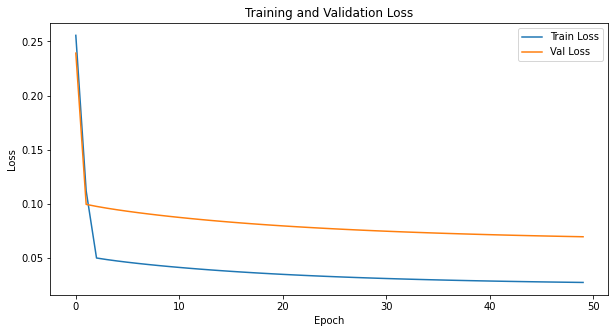

In [40]:
# 初始化优化后的模型
model = OptimizedConv3DNet(sequence_length=5)

# 示例调用
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, save_path='/root/3DCNN/final_model.pth')

# 示例调用
plot_losses(train_losses, val_losses, save_path='/root/3DCNN/3dCNN_loss_plot.png')


### 模型评估与作图
该模块实现了对模型性能的评估和可视化，包括计算均方误差（MSE）、峰值信噪比（PSNR）、结构相似性指数（SSIM）以及信息熵，并绘制验证集的真实图像和预测图像的对比图，标注各个评估指标。

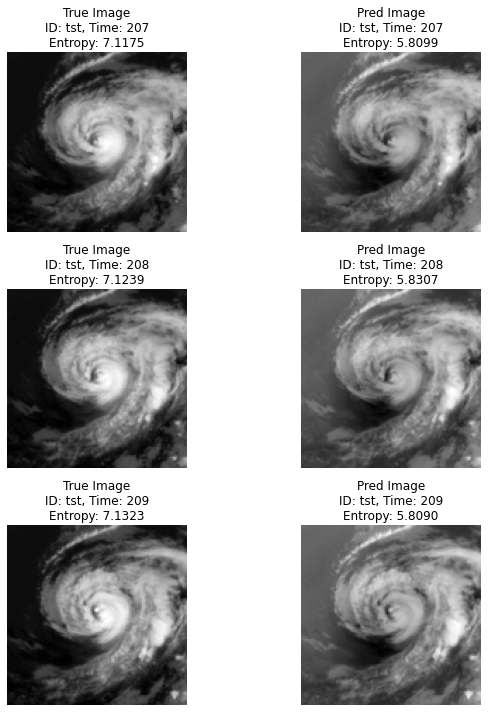

In [41]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
from scipy.stats import entropy

# 计算MSE
def calculate_mse(true_img, pred_img):
    return np.mean((true_img - pred_img) ** 2)

# 计算PSNR
def calculate_psnr(true_img, pred_img):
    mse = calculate_mse(true_img, pred_img)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# 计算SSIM
def calculate_ssim(true_img, pred_img):
    return abs(ssim(pred_img, true_img, data_range=abs(true_img.max() - true_img.min())))

# 计算信息熵
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

# 画出验证集的真实值和差异图对比图，并标注评估指标
def plot_predictions(model, val_loader, sequence_length=5, num_samples=3, custom_ids=None, custom_times=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    sequences, targets = next(iter(val_loader))
    sequences, targets = sequences.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(sequences)

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 10))  # 调整图像大小
    fig.subplots_adjust(hspace=0.3, wspace=0.05)  # 减小图像之间的距离

    for i in range(num_samples):  # 绘制指定数量的样本
        img_id = custom_ids[i] if custom_ids is not None else i
        time_id = custom_times[i] if custom_times is not None else sequence_length + i

        true_img = targets[i].cpu().squeeze().numpy()
        pred_img = outputs[i].cpu().squeeze().numpy()

        entropy_value1 = calculate_entropy(pred_img)
        entropy_value2 = calculate_entropy(true_img)

        # 绘制真实图像
        axs[i, 0].imshow(true_img, cmap='gray')
        axs[i, 0].set_title(f'True Image\nID: tst, Time: {time_id}\nEntropy: {entropy_value2:.4f}')
        axs[i, 0].axis('off')

        # 绘制预测图像
        axs[i, 1].imshow(diff_img, cmap='gray')
        axs[i, 1].set_title(f'Pred Image\nID: tst, Time: {time_id}\nEntropy: {entropy_value1:.4f}')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
plot_predictions(model, val_loader, custom_ids=custom_ids, custom_times=custom_times)
